# Neural Network Code for Brain Segmentation #

This code is split into a few different parts (order is borrowed from Notebook 12_Kaggle_Competition. 
A few random notes: 
- Split data into training/validation/testing BEFORE THIS. Do it patient wise to prevent data leakage. (done)
- Randomize in this code (done)\

    - Slice indexing
    build_slice_index() walks through each patient folder and sorts slices by DICOM InstanceNumber (or filename if missing).

    So within each patient, slices are in anatomical order (inferior → superior, etc.).
  
    Dataset creation

  
    The full list of slices for all patients is concatenated in order of patient ID.
  
    When you pass this to BrainMetSlices, the dataset keeps that deterministic order.



    DataLoader behavior
    The train_loader uses shuffle=True, which means PyTorch shuffles the index order at batch loading time on every epoch.


    So, although the dataset itself is sequential, your batches are randomized every epoch.




- Do data manipulation by Epoch (normal, intensity increase 10%, flip, etc) (done)

1. Data processing (Done)

        i. Import data (Patients + masks)
   
       ii. Class
           a. Preprocessing:
               - Remove DICOM headers

               - Add flipping and intensity jittering to training set. 

           
           b. Dataloader:
               - Convert data to tensors


In [ ]:
from pathlib import Path
from typing import List, Tuple, Optional, Callable, Union
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import SimpleITK as sitk
import re
import random
import pydicom
import math
import torch.nn.functional as F


# ----------------- CONFIG -----------------
ROOT = Path("/config/workspace/projects/local/MLproject/ML project")
RNG_SEED = 42
VAL_FRACTION = 0.15   # of TRAIN (patient-wise)
TEST_FRACTION = 0.20  # patient-wise
# --- add this near config ---
TARGET_SIZE = (256, 256)  # (H, W). Use 512 if you prefer; must be consistent.
# ------------------------------------------
'''
WHAT DOES THIS CODE DO?
Discovers patients: finds folders named p\d+ under ROOT.
Locates cleaned data per patient: {patient}/cleaned/ZZ.DS.OMMA.p**_MRI_slices and _Mask_slices.
Pairs slices: sorts by InstanceNumber; if available, pairs image↔mask by SOPInstanceUID (best), else pairs by index with a warning.
Builds a slice index: a flat list of {patient, img_path, mask_path} rows.
Splits by patient: train/val/test by patient to avoid data leakage.
Creates PyTorch datasets & loaders: that feed your model.
'''

def is_patient_dir(p: Path) -> bool:
    return p.is_dir() and re.match(r"^p\d+$", p.name, flags=re.I) is not None

def find_cleaned_dirs(patient_dir: Path):
    """
    Return (img_dir, mask_dir) under {patient}/cleaned/.
    Expects:
      ZZ.DS.OMMA.p**_MRI_slices
      ZZ.DS.OMMA.p**_Mask_slices
    """
    cleaned = patient_dir / "cleaned"
    if not cleaned.is_dir():
        return None, None
    # Look for dirs that end with *_MRI_slices and *_Mask_slices
    img_dir = None
    mask_dir = None
    for d in cleaned.iterdir():
        if not d.is_dir():
            continue
        name = d.name.lower()
        if name.endswith("_mri_slices"):
            img_dir = d
        elif name.endswith("_mask_slices"):
            mask_dir = d
    return img_dir, mask_dir

def list_dicom_sorted(d: Path):
    """List DICOM files in a directory sorted by InstanceNumber (fallback filename)."""
    files = [f for f in d.iterdir() if f.is_file()]
    def sort_key(p: Path):
        try:
            ds = pydicom.dcmread(str(p), stop_before_pixels=True, force=True)
            inst = getattr(ds, "InstanceNumber", None)
            return (inst if inst is not None else 10**9, p.name)
        except Exception:
            return (10**9, p.name)
    return sorted(files, key=sort_key)

def map_by_uid(img_files, mask_files):
    """
    Try to pair by SOPInstanceUID; fallback to index pairing if UIDs missing or mismatch count.
    Return list of tuples (img_path, mask_path).
    """
    # Build UID maps
    def uid_map(files):
        m = {}
        for f in files:
            try:
                ds = pydicom.dcmread(str(f), stop_before_pixels=True, force=True)
                uid = str(getattr(ds, "SOPInstanceUID", ""))
                if uid:
                    m[uid] = f
            except Exception:
                pass
        return m

    img_uids = uid_map(img_files)
    mask_uids = uid_map(mask_files)

    pairs = []
    if img_uids and mask_uids:
        common = [u for u in img_uids.keys() if u in mask_uids]
        if len(common) >= min(len(img_files), len(mask_files)) * 0.9:
            # Pair on UIDs
            for u in sorted(common):  # sort for deterministic order
                pairs.append((img_uids[u], mask_uids[u]))
            # Warn if not 1:1
            if len(common) != len(img_files) or len(common) != len(mask_files):
                print(f"[WARN] UID pairing dropped some slices: {len(common)} pairs, "
                      f"{len(img_files)} images, {len(mask_files)} masks")
            return pairs

    # Fallback: index pairing after sorting
    n = min(len(img_files), len(mask_files))
    if len(img_files) != len(mask_files):
        print(f"[WARN] Index pairing with unequal counts: images={len(img_files)} masks={len(mask_files)}")
    for i in range(n):
        pairs.append((img_files[i], mask_files[i]))
    return pairs

def dicom_to_image(ds):
    """Convert DICOM dataset to float32 numpy array, applying RescaleSlope/Intercept."""
    arr = ds.pixel_array.astype(np.float32, copy=False)
    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    if slope != 1.0 or intercept != 0.0:
        arr = arr * slope + intercept
    return arr

def read_dicom(path: Path, stop_before_pixels=False):
    return pydicom.dcmread(str(path), stop_before_pixels=stop_before_pixels, force=True)

def build_slice_index(root: Path):
    """
    Return a list of dicts:
      {"patient": "p014", "img": Path, "mask": Path}
    Only includes patients with both dirs and at least 1 paired slice.
    """
    patients = [p for p in root.iterdir() if is_patient_dir(p)]
    index = []
    for pd in sorted(patients, key=lambda x: int(re.findall(r"\d+", x.name)[0])):
        img_dir, mask_dir = find_cleaned_dirs(pd)
        if not img_dir or not mask_dir:
            print(f"[SKIP] {pd.name}: cleaned MRI/mask dirs not found")
            continue
        img_files = list_dicom_sorted(img_dir)
        mask_files = list_dicom_sorted(mask_dir)
        if not img_files or not mask_files:
            print(f"[SKIP] {pd.name}: no DICOM files in cleaned dirs")
            continue
        pairs = map_by_uid(img_files, mask_files)
        if not pairs:
            print(f"[SKIP] {pd.name}: no slice pairs")
            continue
        for img_p, mask_p in pairs:
            index.append({"patient": pd.name, "img": img_p, "mask": mask_p})
    return index

def _resize_2d(t: torch.Tensor, size_hw: tuple[int,int], mode: str, align_corners: bool | None):
    """
    t: [H, W] or [1, H, W]; returns [H, W]
    mode: 'bilinear' for image, 'nearest' for mask
    """
    if t.ndim == 2:
        t = t.unsqueeze(0)  # [1, H, W]
    t = t.unsqueeze(0)      # [1, 1, H, W]
    out = F.interpolate(t, size=size_hw, mode=mode, align_corners=align_corners)  # [1,1,h,w]
    return out.squeeze(0).squeeze(0)  # [h, w]
    
def split_by_patient(index, test_fraction=0.2, val_fraction=0.15, seed=RNG_SEED):
    """
    Patient-wise split to avoid leakage:
      - Pick TEST_FRACTION of patients for test
      - From remaining, pick VAL_FRACTION for val
    Returns dict with 'train', 'val', 'test' lists of index rows.
    """
    rng = random.Random(seed)
    patients = sorted({row["patient"] for row in index})
    rng.shuffle(patients)
    n = len(patients)
    n_test = max(1, int(round(n * test_fraction)))
    test_patients = set(patients[:n_test])
    remaining = patients[n_test:]
    n_val = max(1, int(round(len(remaining) * val_fraction))) if remaining else 0
    val_patients = set(remaining[:n_val])
    train_patients = set(remaining[n_val:])

    split = {"train": [], "val": [], "test": []}
    for row in index:
        if row["patient"] in test_patients:
            split["test"].append(row)
        elif row["patient"] in val_patients:
            split["val"].append(row)
        else:
            split["train"].append(row)
    print(f"Patients total={n} | train={len(train_patients)} val={len(val_patients)} test={len(test_patients)}")
    print(f"Slices   train={len(split['train'])} val={len(split['val'])} test={len(split['test'])}")
    return split

def resize_collate(batch):
    # batch is a list of (img[1,H,W], mask[1,H,W], meta_dict)
    imgs, msks, metas = zip(*batch)   # metas stays as tuple of dicts
    imgs = torch.stack(imgs, dim=0)   # [B,1,H,W]
    msks = torch.stack(msks, dim=0)   # [B,1,H,W]
    return imgs, msks, list(metas)
# Add class which can augment training data
from dataclasses import dataclass
@dataclass

class AugmentConfig:
    """Holds parameters controlling data augmentation strength."""
    p_flip_lr: float = 0.5                 # probability of left-right flip (mirror across Y-axis)
    contrast_range: tuple[float, float] = (0.9, 1.1)
    brightness_range: tuple[float, float] = (-0.1, 0.1)
    p_gamma: float = 0.3
    gamma_range: tuple[float, float] = (0.9, 1.1)
    p_gauss_noise: float = 0.3
    gauss_sigma: float = 0.05             # std dev of additive Gaussian noise (z-score units)


def _rand_uniform(a: float, b: float, rng: np.random.Generator) -> float:
    return float(rng.uniform(a, b))


def augment_flip_lr(img: np.ndarray, msk: np.ndarray,
                    rng: np.random.Generator, p: float) -> tuple[np.ndarray, np.ndarray]:
    """Random horizontal (Y-axis) flip applied to both image and mask."""
    if rng.random() < p:
        img = np.ascontiguousarray(img[:, ::-1])
        msk = np.ascontiguousarray(msk[:, ::-1])
    return img, msk


def augment_intensity(img: np.ndarray, rng: np.random.Generator,
                      cfg: AugmentConfig) -> np.ndarray:
    """Apply mild random intensity changes to an already z-scored image."""
    # Contrast (multiply) and brightness (add)
    c = _rand_uniform(*cfg.contrast_range, rng)
    b = _rand_uniform(*cfg.brightness_range, rng)
    img = img * c + b

    # Optional gamma (nonlinear brightness curve)
    if rng.random() < cfg.p_gamma:
        vmin, vmax = float(img.min()), float(img.max())
        if vmax > vmin:
            x = (img - vmin) / (vmax - vmin)
            gamma = _rand_uniform(*cfg.gamma_range, rng)
            x = np.power(x, gamma)
            img = x * (vmax - vmin) + vmin

    # Optional Gaussian noise
    if rng.random() < cfg.p_gauss_noise:
        img = img + rng.normal(0.0, cfg.gauss_sigma, size=img.shape).astype(img.dtype)

    return img
class BrainMetSlices(Dataset):
    """
    Returns (image, mask, meta) per 2D slice.
    image: torch.float32 [1,H,W], z-scored and resized
    mask : torch.int64  [1,H,W], binary
    """
    def __init__(self, rows, binarize_threshold=0.5, zscore=True, target_size=(256,256),
                 augment: bool = False, aug_cfg: AugmentConfig | None = None, seed: int = 1234):
        self.rows = rows
        self.binarize_threshold = binarize_threshold
        self.zscore = zscore
        self.target_size = target_size
        self.augment = augment
        self.aug_cfg = aug_cfg if aug_cfg is not None else AugmentConfig()
        # per-dataset RNG (so workers get different streams even with same seed)
        self._seed = seed
        self._rng = np.random.default_rng(seed)

    def __len__(self):
        return len(self.rows)

    def __getitem__(self, i):
        rec = self.rows[i]
        ds_img = read_dicom(rec["img"])
        ds_msk = read_dicom(rec["mask"])

        img = dicom_to_image(ds_img).astype(np.float32)  # [H,W]
        msk = ds_msk.pixel_array.astype(np.float32, copy=False)  # [H,W]

        # Robust mask binarization
        vmax = float(msk.max()) if msk.size > 0 else 1.0
        if vmax > 0:
            msk = msk / vmax
        msk = (msk >= self.binarize_threshold).astype(np.int64)

        # We apply z-score first → jitter operates in a consistent scale.
        if self.zscore:
            mu = float(img.mean()); sd = float(img.std())
            img = (img - mu) / sd if sd > 0 else (img - mu)

        # --- AUGMENTATIONS (train only) ---
        if self.augment:
            # Make a per-sample RNG by mixing index and base seed (stable across epochs)
            rng = np.random.default_rng((self._seed + i) & 0xFFFFFFFF)
            # Spatial flip (apply to image and mask)
            img, msk = augment_flip_lr(img, msk, rng, self.aug_cfg.p_flip_lr)
            # Intensity jitter (image only)
            img = augment_intensity(img, rng, self.aug_cfg)

        # To tensors
        img_t = torch.from_numpy(img).to(torch.float32)
        msk_t = torch.from_numpy(msk).to(torch.int64)

        # Resize to common size (image bilinear, mask nearest)
        if self.target_size is not None:
            img_t = _resize_2d(img_t, self.target_size, mode="bilinear", align_corners=False)
            msk_t = _resize_2d(msk_t.to(torch.float32), self.target_size, mode="nearest", align_corners=None).to(torch.int64)

        # Channel-first
        img_t = img_t.unsqueeze(0)
        msk_t = msk_t.unsqueeze(0)

        meta = {"patient": rec["patient"], "img_path": str(rec["img"]), "mask_path": str(rec["mask"])}
        return img_t, msk_t, meta

In [2]:
# ----------------- BUILD INDEX & SPLIT -----------------
index = build_slice_index(ROOT)
if not index:
    raise RuntimeError("No slice pairs found. Check folder names and DICOM contents.")

split = split_by_patient(index, test_fraction=TEST_FRACTION, val_fraction=VAL_FRACTION, seed=RNG_SEED)

#Turn on data augment for training set ONLY
train_ds = BrainMetSlices(split["train"], augment=True, aug_cfg=AugmentConfig(), seed=42)
val_ds   = BrainMetSlices(split["val"],   augment=False)
test_ds  = BrainMetSlices(split["test"],  augment=False)

# Example loaders (adjust batch_size/num_workers to taste)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=0, collate_fn=resize_collate)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=0, collate_fn=resize_collate)
test_loader  = DataLoader(test_ds,  batch_size=8, shuffle=False, num_workers=0, collate_fn=resize_collate)

# --------------- QUICK SMOKE TEST ---------------
b_img, b_msk, b_meta = next(iter(train_loader))
print("Batch image:", b_img.shape, b_img.dtype, "min/max", float(b_img.min()), float(b_img.max()))
print("Batch mask :", b_msk.shape, b_msk.dtype, "unique", torch.unique(b_msk))
print("Sample meta:", b_meta[0])


[SKIP] p02: cleaned MRI/mask dirs not found
Patients total=28 | train=19 val=3 test=6
Slices   train=1753 val=416 test=685
Batch image: torch.Size([8, 1, 256, 256]) torch.float32 min/max -1.0142455101013184 6.806724548339844
Batch mask : torch.Size([8, 1, 256, 256]) torch.int64 unique tensor([0, 1])
Sample meta: {'patient': 'p029', 'img_path': '/config/workspace/projects/local/MLproject/ML project/p029/cleaned/ZZ.DS.OMMA.p029_MRI_slices/patient029_slice_235_tumor_0.dcm', 'mask_path': '/config/workspace/projects/local/MLproject/ML project/p029/cleaned/ZZ.DS.OMMA.p029_Mask_slices/patient029_slice_235_tumor_0.dcm'}


# unet architecture 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

class DoubleConv(nn.Module):
    """(Conv -> BN? -> ReLU) x 2"""
    def __init__(self, in_ch, out_ch, use_bn=True, dropout=0.0): #no droppout 
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=not use_bn), # 3x3 kernal with padding = 1 so that maintains the same HxW
        ]
        if use_bn: layers.append(nn.BatchNorm2d(out_ch)) # stabilizes training and prevent exploding gradients
        layers.append(nn.ReLU(inplace=True))  # ReLu acivation to save GPU memory

        layers += [
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=not use_bn),
        ]
        if use_bn: layers.append(nn.BatchNorm2d(out_ch))
        layers.append(nn.ReLU(inplace=True))

        if dropout > 0:
            layers.append(nn.Dropout2d(p=dropout))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    """Downscale: MaxPool -> DoubleConv"""
    def __init__(self, in_ch, out_ch, use_bn=True, dropout=0.0):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch, use_bn, dropout)

    def forward(self, x):
        return self.conv(self.pool(x))

class Up(nn.Module):
    """Upscale: ConvTranspose2d -> concat skip -> DoubleConv"""
    def __init__(self, in_ch, out_ch, use_bn=True, dropout=0.0):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch, use_bn, dropout)

    @staticmethod
    def _center_crop(skip, target_spatial):
        # Handle odd shapes from pooling/upsampling
        _, _, H, W = skip.shape
        h, w = target_spatial
        dh = (H - h) // 2
        dw = (W - w) // 2
        return skip[:, :, dh:dh + h, dw:dw + w]

    def forward(self, x, skip):
        x = self.up(x)                      # [B, C/2, 2H, 2W]
        if x.shape[-2:] != skip.shape[-2:]:
            skip = self._center_crop(skip, x.shape[-2:])
        x = torch.cat([skip, x], dim=1)     # channel concat
        return self.conv(x)

class UNet(nn.Module):
    """
    U-Net (2D).
    - in_channels: image channels (yours = 1)
    - num_classes: 1 for binary (logit); >1 for multi-class (logits per class)
    - base_ch: width of first stage
    """
    def __init__(self, in_channels=1, num_classes=1, base_ch=64, use_bn=True, dropout=0.0):
        super().__init__()
        # Encoder
        self.inc = DoubleConv(in_channels, base_ch, use_bn, dropout=0.0)
        self.down1 = Down(base_ch, base_ch*2, use_bn, dropout=dropout)
        self.down2 = Down(base_ch*2, base_ch*4, use_bn, dropout=dropout)
        self.down3 = Down(base_ch*4, base_ch*8, use_bn, dropout=dropout)
        self.down4 = Down(base_ch*8, base_ch*16, use_bn, dropout=dropout)

        # Decoder
        self.up1 = Up(base_ch*16, base_ch*8, use_bn, dropout=dropout)
        self.up2 = Up(base_ch*8,  base_ch*4, use_bn, dropout=dropout)
        self.up3 = Up(base_ch*4,  base_ch*2, use_bn, dropout=dropout)
        self.up4 = Up(base_ch*2,  base_ch,   use_bn, dropout=dropout)

        self.outc = nn.Conv2d(base_ch, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)     # [B, 64, H, W]
        x2 = self.down1(x1)  # [B, 128, H/2, W/2]
        x3 = self.down2(x2)  # [B, 256, H/4, W/4]
        x4 = self.down3(x3)  # [B, 512, H/8, W/8]
        x5 = self.down4(x4)  # [B, 1024,H/16,W/16]
        # Decoder with skips
        x = self.up1(x5, x4)
        x = self.up2(x,  x3)
        x = self.up3(x,  x2)
        x = self.up4(x,  x1)
        logits = self.outc(x)  # [B, num_classes, H, W]
        return logits

# Binary segmentation (one lesion class):
model = UNet(in_channels=1, num_classes=1, base_ch=64, use_bn=True, dropout=0.1)

# Multi-class (e.g., background + two labels):
# model = UNet(in_channels=1, num_classes=3, base_ch=32)        

def dice_coeff(pred, target, eps=1e-6):
    # pred, target: [B,1,H,W], pred are probabilities (after sigmoid)
    pred = pred.squeeze(1)
    target = target.squeeze(1).float()
    intersection = (pred * target).sum(dim=(1,2))
    union = pred.sum(dim=(1,2)) + target.sum(dim=(1,2))
    dice = (2*intersection + eps) / (union + eps)
    return dice.mean()

bce = nn.BCEWithLogitsLoss()

def bce_dice_loss(logits, target):
    bce_loss = bce(logits, target.float())
    probs = torch.sigmoid(logits)
    dice = dice_coeff(probs, target)
    return bce_loss + (1 - dice)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

for imgs, msks, metas in train_loader:
    imgs = imgs.to(device)                 # [B,1,256,256], float32
    msks = msks.to(device)                 # [B,1,256,256], int64 (0/1)
    logits = model(imgs)                   # [B,1,256,256]
    loss = bce_dice_loss(logits, msks)     # BCE + Dice
    opt.zero_grad()
    loss.backward()
    opt.step()
x = torch.randn(2, 1, 256, 256)
y = model(x)
print(y.shape)  # binary: [2, 1, 256, 256]

torch.Size([2, 1, 256, 256])


Epoch 01: loss=1.1387, lr=0.001000
Epoch 02: loss=0.9204, lr=0.000999
Epoch 03: loss=0.7517, lr=0.000997
Epoch 04: loss=0.6945, lr=0.000995
Epoch 05: loss=0.6539, lr=0.000992
Epoch 06: loss=0.6328, lr=0.000989
Epoch 07: loss=0.6121, lr=0.000985
Epoch 08: loss=0.5986, lr=0.000981
Epoch 09: loss=0.5832, lr=0.000976
Epoch 10: loss=0.5720, lr=0.000970
Epoch 11: loss=0.5659, lr=0.000964
Epoch 12: loss=0.5509, lr=0.000957
Epoch 13: loss=0.5429, lr=0.000949
Epoch 14: loss=0.5375, lr=0.000941
Epoch 15: loss=0.5371, lr=0.000933
Epoch 16: loss=0.5412, lr=0.000924
Epoch 17: loss=0.5241, lr=0.000915
Epoch 18: loss=0.5168, lr=0.000905
Epoch 19: loss=0.5108, lr=0.000894
Epoch 20: loss=0.5207, lr=0.000883
Epoch 21: loss=0.5220, lr=0.000872
Epoch 22: loss=0.5097, lr=0.000860
Epoch 23: loss=0.5000, lr=0.000847
Epoch 24: loss=0.5072, lr=0.000835
Epoch 25: loss=0.5005, lr=0.000821
Epoch 26: loss=0.4957, lr=0.000808
Epoch 27: loss=0.4976, lr=0.000794
Epoch 28: loss=0.4853, lr=0.000780
Epoch 29: loss=0.488

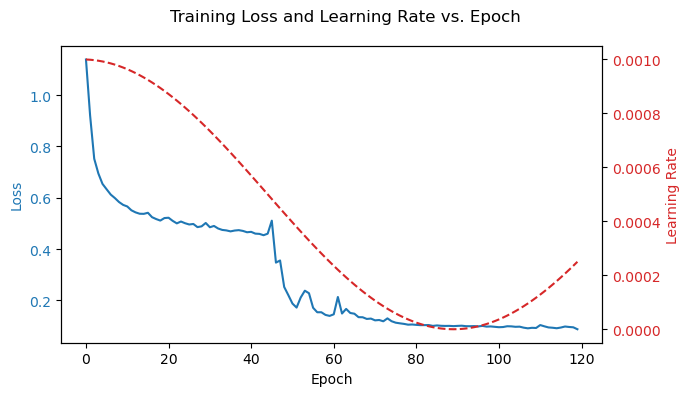

In [6]:
import torch 
# --- training loop with logging ---
num_epochs = 120
loss_history = []
lr_history = []


# --- setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, num_classes=1, base_ch=32).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#Learning rate initial = 1e-3
scheduler = CosineAnnealingLR(opt, T_max=0.75*num_epochs)  # optional, for smooth LR decay. T_max is the minimum on the cosfunction. Changed to match num_epochs
criterion = bce_dice_loss  # from previous code



for epoch in range(num_epochs):
    try:
        model.train()
        epoch_loss = 0.0
        for imgs, msks, _ in train_loader:
            imgs, msks = imgs.to(device), msks.to(device)
            opt.zero_grad()
            logits = model(imgs)
            loss = criterion(logits, msks.float()) #Changed masks to float instead of int so they all have the same data type
            if not torch.isfinite(loss):
                print(f"[ERROR] Non-finite loss at epoch {epoch+1}")
                raise RuntimeError("Non-finite loss")
            loss.backward()
            opt.step()
            epoch_loss += loss.item() * imgs.size(0)
        scheduler.step()

        mean_loss = epoch_loss / len(train_loader.dataset)
        loss_history.append(mean_loss)
        lr_history.append(opt.param_groups[0]['lr'])
        print(f"Epoch {epoch+1:02d}: loss={mean_loss:.4f}, lr={opt.param_groups[0]['lr']:.6f}")
    except:
        print(f"[FATAL] Exception at epoch {epoch+1}: {e}")
        raise
# --- plot loss and LR ---
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(loss_history, color='tab:blue', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(lr_history, color='tab:red', linestyle='--', label='Learning Rate')
ax2.set_ylabel('Learning Rate', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.suptitle("Training Loss and Learning Rate vs. Epoch")
fig.tight_layout()
plt.show()

# Deturmine if model correctly detects if there is any tumor in the image

In [7]:
import torch
from torch.nn.functional import sigmoid

@torch.no_grad()
def eval_tumor_presence(model, loader, device, prob_thresh=0.5, min_positive_pixels=1):
    """
    Evaluate how well the model detects presence/absence of tumor in a slice.

    - Ground truth positive if mask has >= 1 positive pixel.
    - Predicted positive if predicted mask (after sigmoid + threshold) has
      at least `min_positive_pixels` pixels set to 1.
    """
    model.eval()
    tp = tn = fp = fn = 0

    for imgs, msks, _ in loader:
        imgs = imgs.to(device)
        msks = msks.to(device)  # [B,1,H,W], int64 0/1

        logits = model(imgs)
        probs  = torch.sigmoid(logits)     # [B,1,H,W]
        preds  = (probs >= prob_thresh).to(torch.int64)

        # Flatten per-slice
        preds_flat  = preds.view(preds.size(0), -1)
        masks_flat  = msks.view(msks.size(0), -1)

        # Per-slice "has tumor" flags
        pred_has_tumor = (preds_flat.sum(dim=1) >= min_positive_pixels)  # bool
        true_has_tumor = (masks_flat.sum(dim=1)  > 0)                    # bool

        for p, t in zip(pred_has_tumor, true_has_tumor):
            if t and p:
                tp += 1
            elif (not t) and (not p):
                tn += 1
            elif (not t) and p:
                fp += 1
            elif t and (not p):
                fn += 1

    total = tp + tn + fp + fn
    acc = (tp + tn) / total if total > 0 else 0.0
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    metrics = {
        "accuracy": acc,
        "sensitivity": sens,
        "specificity": spec,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "total_slices": total,
    }
    return metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_metrics = eval_tumor_presence(model, val_loader, device, prob_thresh=0.5, min_positive_pixels=1)
print("Validation metrics (tumor presence):")
for k, v in val_metrics.items():
    print(f"{k}: {v}")


Validation metrics (tumor presence):
accuracy: 0.7716346153846154
sensitivity: 0.7222222222222222
specificity: 0.9456521739130435
TP: 234
TN: 87
FP: 5
FN: 90
total_slices: 416


# Visualize Training

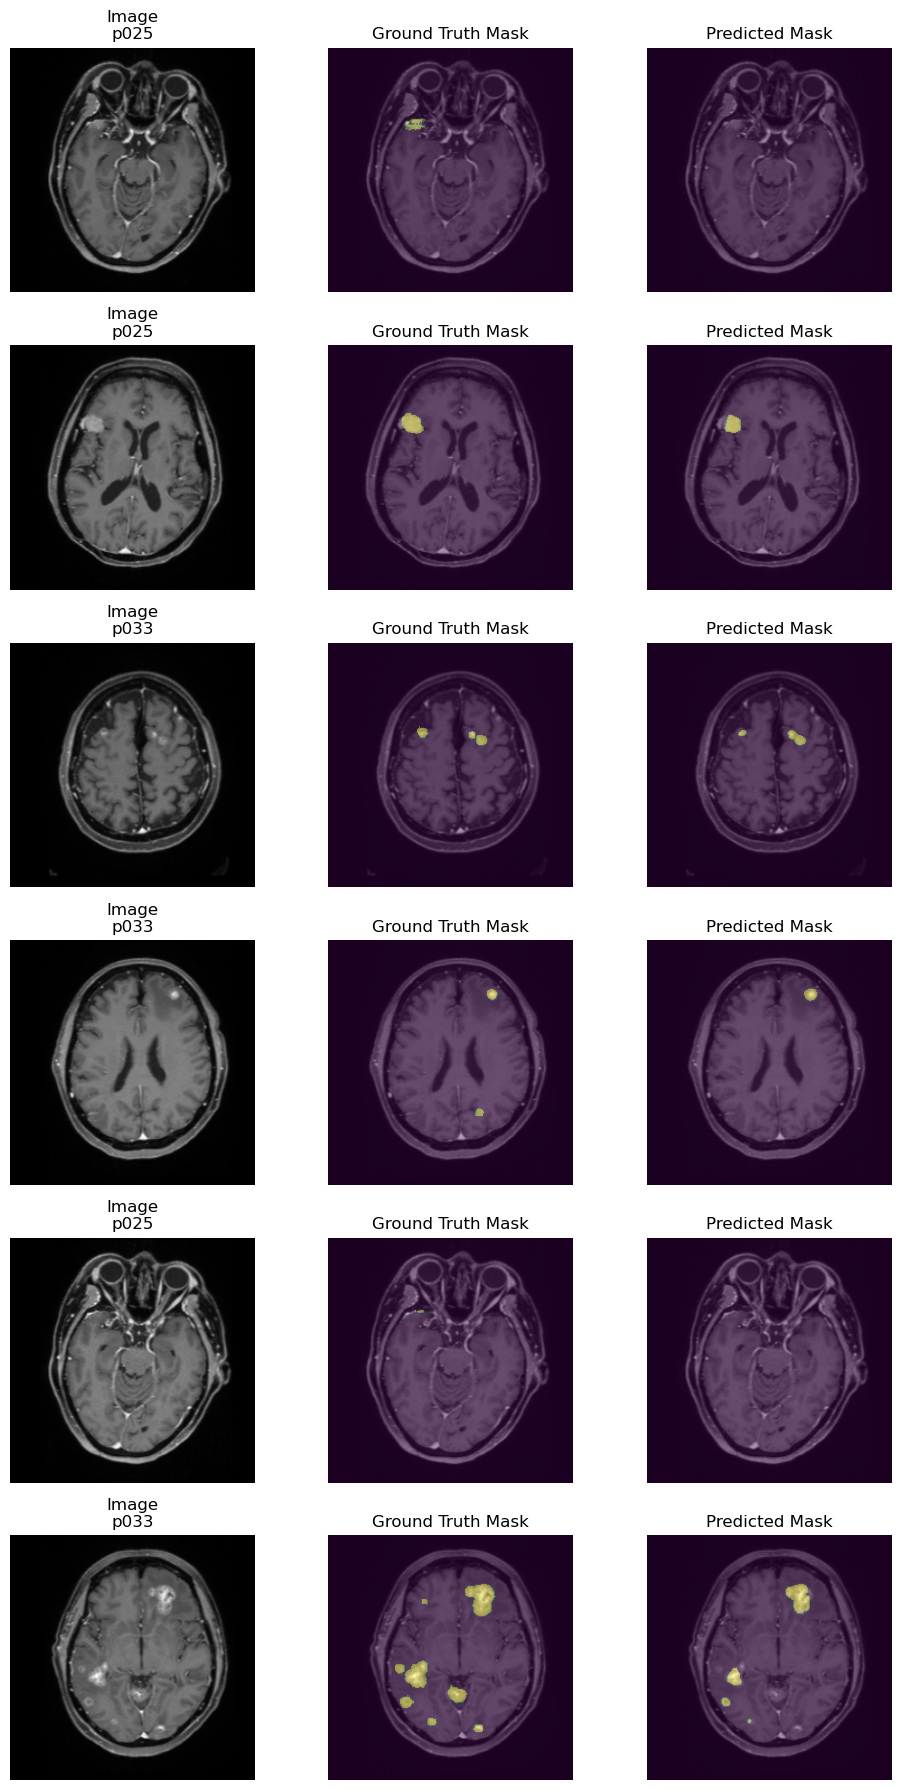

In [19]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_random_predictions(
    model,
    dataset,
    device,
    num_examples: int = 6,
    prob_thresh: float = 0.5,
    seed: int | None = None
):
    """
    Visualize a random mix of tumor and non-tumor slices.
    Displays MR image, ground-truth mask, and predicted mask.
    """

    model.eval()

    # Optional: true randomness if seed=None
    if seed is not None:
        random.seed(seed)

    # Choose random indices from entire dataset
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)

    # Pick the first N after shuffling
    selected = all_indices[:num_examples]

    fig, axes = plt.subplots(num_examples, 3, figsize=(10, 3 * num_examples))
    if num_examples == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, idx in enumerate(selected):
        img_t, msk_t, meta = dataset[idx]

        # Move to GPU/CPU for inference
        logits = model(img_t.unsqueeze(0).to(device))   # [1,1,H,W]
        probs = torch.sigmoid(logits)[0, 0].cpu().numpy()
        pred_mask = (probs >= prob_thresh).astype(np.uint8)

        true_mask = msk_t[0].numpy()
        image_np = img_t[0].numpy()

        ax_img, ax_true, ax_pred = axes[row]

        # (1) Original MRI
        ax_img.imshow(image_np, cmap="gray")
        ax_img.set_title(f"Image\n{meta['patient']}")
        ax_img.axis("off")

        # (2) Ground-truth mask overlay
        ax_true.imshow(image_np, cmap="gray")
        ax_true.imshow(true_mask, alpha=0.4)
        ax_true.set_title("Ground Truth Mask")
        ax_true.axis("off")

        # (3) Predicted mask overlay
        ax_pred.imshow(image_np, cmap="gray")
        ax_pred.imshow(pred_mask, alpha=0.4)
        ax_pred.set_title("Predicted Mask")
        ax_pred.axis("off")

    plt.tight_layout()
    plt.show()


visualize_random_predictions(model, val_ds, device, num_examples=6, prob_thresh=0.5)


In [ ]:
## TESTS 
#Test to see the data sizes and types of everything to check for easy fixes
# Get one batch from your training loader
imgs, msks, _ = next(iter(train_loader))

print("=== INPUT BATCH ===")
print("images.shape:", imgs.shape)
print("images.dtype:", imgs.dtype)
print("images.min():", imgs.min().item())
print("images.max():", imgs.max().item())

print("\nmask.shape:", msks.shape)
print("mask.dtype:", msks.dtype)
print("mask.min():", msks.min().item())
print("mask.max():", msks.max().item())
print("unique mask values:", torch.unique(msks))

# Now check model output on this batch (no grad)
model.eval()
with torch.no_grad():
    preds = model(imgs.to(device))

print("\n=== MODEL OUTPUT ===")
print("preds.shape:", preds.shape)
print("preds.dtype:", preds.dtype)
print("preds.min():", preds.min().item())
print("preds.max():", preds.max().item())

=== INPUT BATCH ===
images.shape: torch.Size([8, 1, 256, 256])
images.dtype: torch.float32
images.min(): -0.9754064679145813
images.max(): 6.581286907196045

mask.shape: torch.Size([8, 1, 256, 256])
mask.dtype: torch.int64
mask.min(): 0
mask.max(): 1
unique mask values: tensor([0, 1])

=== MODEL OUTPUT ===
preds.shape: torch.Size([8, 1, 256, 256])
preds.dtype: torch.float32
preds.min(): -7.886373996734619
preds.max(): 14.4127779006958


In [17]:
# Take a tiny subset: 1 batch, or even 2 images
small_imgs, small_msks, _ = next(iter(train_loader))
small_imgs = small_imgs.to(device)
small_msks = small_msks.to(device)

model.train()
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

for step in range(301):
    opt.zero_grad()
    logits = model(small_imgs)
    loss   = criterion(logits, small_msks.float())
    loss.backward()
    opt.step()
    
    if step % 50 == 0:
        print(f"step {step}: loss = {float(loss):.4f}")

/tmp/ipykernel_871927/1879426780.py:18: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print(f"step {step}: loss = {float(loss):.4f}")


step 0: loss = 0.0061
step 50: loss = 0.0013
step 100: loss = 0.0005
step 150: loss = 0.0004
step 200: loss = 0.0002
step 250: loss = 0.0001
step 300: loss = 0.0001


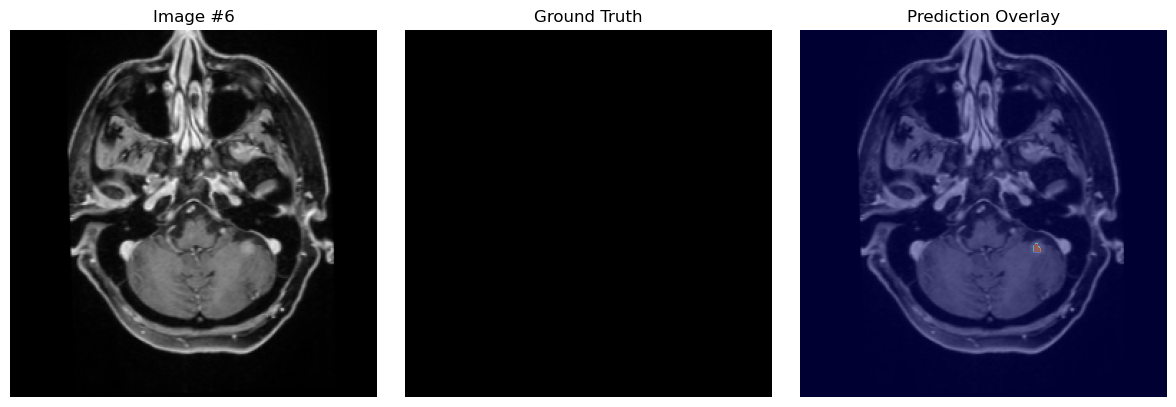

In [28]:


model.eval()
imgs, msks, _ = next(iter(val_loader))   # or train_loader
imgs, msks = imgs.to(device), msks.to(device)

with torch.no_grad():
    logits = model(imgs)
    probs  = torch.sigmoid(logits)
    preds  = (probs > 0.5).float()

# pick a random index within this batch
idx = torch.randint(0, imgs.size(0), (1,)).item()

img  = imgs[idx, 0].cpu().numpy()
gt   = msks[idx, 0].cpu().numpy()
pred = preds[idx, 0].cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(img, cmap="gray")
axs[0].set_title(f"Image #{idx}")
axs[0].axis("off")

axs[1].imshow(gt, cmap="gray")
axs[1].set_title("Ground Truth")
axs[1].axis("off")

axs[2].imshow(img, cmap="gray")
axs[2].imshow(pred, cmap="jet", alpha=0.4)
axs[2].set_title("Prediction Overlay")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [29]:
for i in range(imgs.size(0)):
    print(f"idx {i}: GT mask sum = {msks[i].sum().item()}")

idx 0: GT mask sum = 0
idx 1: GT mask sum = 0
idx 2: GT mask sum = 0
idx 3: GT mask sum = 0
idx 4: GT mask sum = 0
idx 5: GT mask sum = 0
idx 6: GT mask sum = 0
idx 7: GT mask sum = 0


In [31]:
axs[1].imshow(gt, cmap="gray")

In [32]:
print("num positive:", gt.sum())

num positive: 0


In [33]:
axs[1].imshow(gt > 0.5, cmap="gray")

In [57]:
def show_random_positive_sample(model, loader, device):
    model.eval()
    imgs, msks, _ = next(iter(loader))
    imgs, msks = imgs.to(device), msks.to(device)

    # find indices with non-empty masks
    positive_indices = [i for i in range(imgs.size(0)) if msks[i].sum() > 0]
    if not positive_indices:
        print("No positive masks in this batch; try again.")
        return

    idx = random.choice(positive_indices)

    with torch.no_grad():
        logits = model(imgs)
        probs  = torch.sigmoid(logits)
        preds  = (probs > 0.5).float()

    img  = imgs[idx, 0].cpu().numpy()
    gt   = msks[idx, 0].cpu().numpy()
    pred = preds[idx, 0].cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(img, cmap="gray")
    axs[0].set_title(f"Image idx {idx}")
    axs[0].axis("off")

    axs[1].imshow(gt > 0.5, cmap="gray")  # force binary view
    axs[1].set_title("Ground Truth (binary)")
    axs[1].axis("off")

    axs[2].imshow(img, cmap="gray")
    axs[2].imshow(pred, cmap="jet", alpha=0.4)
    axs[2].set_title("Prediction Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()
show_random_positive_sample(model, val_loader, device)    

No positive masks in this batch; try again.
